In [1]:
import os
import sys

from transformers import AutoModel, AutoTokenizer
import torch
from torch import nn
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import wandb

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader


In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
model = AutoModel.from_pretrained("vinai/phobert-base", output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model.to(device)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

# Data Preparing

In [4]:
train_vlsp_2016 = pd.read_csv('/kaggle/input/vlsp-2016/train.csv')
train_aivivn_2019 = pd.read_csv('/kaggle/input/aivivn-2019/train.csv')

test_vlsp_2016 = pd.read_csv('/kaggle/input/vlsp-2016/test.csv')
test_aivivn_2019 = pd.read_csv('/kaggle/input/aivivn-2019/test.csv')

In [5]:
train_data = pd.concat([train_aivivn_2019, train_vlsp_2016])
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Using PhoBERT with fairseq
Please see details at HERE!

Notes: 
In case the input texts are raw, i.e. without word segmentation, a word segmenter must be applied to produce word-segmented texts before feeding to PhoBERT. As PhoBERT employed the RDRSegmenter from VnCoreNLP to pre-process the pre-training data (including Vietnamese tone normalization and word and sentence segmentation), it is recommended to also use the same word segmenter for PhoBERT-based downstream applications w.r.t. the input raw texts.

In [6]:
!pip install py_vncorenlp --quiet
!mkdir -p /kaggle/working/vncorenlp

# Cài đặt OpenJDK
!apt-get update --quiet > /dev/null 2>&1
!apt-get install -y openjdk-11-jdk --quiet > /dev/null 2>&1

# Đặt biến môi trường JAVA_HOME
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

In [7]:
import py_vncorenlp
# Automatically download VnCoreNLP components from the original repository
# and save them in some local machine folder
py_vncorenlp.download_model(save_dir='/kaggle/working/vncorenlp')

# Load the word and sentence segmentation component
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/kaggle/working/vncorenlp')

--2024-08-01 04:03:24--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412703 (26M) [application/octet-stream]
Saving to: 'VnCoreNLP-1.2.jar'

     0K .......... .......... .......... .......... ..........  0% 3.70M 7s
    50K .......... .......... .......... .......... ..........  0% 4.10M 7s
   100K .......... .......... .......... .......... ..........  0% 6.20M 6s
   150K .......... .......... .......... .......... ..........  0% 21.1M 5s
   200K .......... .......... .......... .......... ..........  0% 31.4M 4s
   250K .......... .......... .......... .......... ..........  1% 7.61M 4s
   300K .......... .......... .......... .......... ..........  1% 43.1M 3s
   350K ..

2024-08-01 04:03:27 INFO  WordSegmenter:24 - Loading Word Segmentation model


# Create DataLoader

In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, segmenter):
        self.tokenizer = tokenizer
        self.segmenter = segmenter
        self.data = dataframe
        self.text = dataframe.comment
        self.targets = dataframe.label

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        # Use segmenter to segment the text
        segmented_text = self.segmenter.word_segment(text)

        # Join segmented text into a single string
        segmented_text = " ".join(segmented_text)

        inputs = self.tokenizer(
            segmented_text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

        ids = inputs['input_ids'].squeeze()
        mask = inputs['attention_mask'].squeeze()

        return {
            'ids': ids.clone().detach(),
            'mask': mask.clone().detach(),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

# Tạo dataloader
def create_dataloader(dataframe, tokenizer, segmenter, batch_size):
    dataset = CustomDataset(dataframe, tokenizer, segmenter)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Custom model with BERT + MLP

In [9]:
def inference(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for data in dataloader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            targets = data['targets'].to(device)

            outputs = model(ids, mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().tolist())
            true_labels.extend(targets.cpu().tolist())
    
    return predictions, true_labels


In [10]:
# Định nghĩa lớp mô hình tùy chỉnh
class PhoBERT(nn.Module):
    def __init__(self, bert_model):
        super(PhoBERT, self).__init__()
        self.bert = bert_model
        self.mlp = nn.Sequential(
            nn.Linear(768 * 5, 512),  # 768*5 cho BERT
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3)  # num_classes là số lượng lớp trong bài toán của bạn
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Lấy 5 lớp ẩn cuối cùng của token [CLS]
        last_hidden_states = outputs.hidden_states[-5:]
        cls_embeddings = torch.cat([state[:, 0, :] for state in last_hidden_states], dim=1)

        # Đưa qua MLP
        logits = self.mlp(cls_embeddings)
        return logits

# Training

In [11]:
from kaggle_secrets import UserSecretsClient

# Tự động nhập API key từ Kaggle Secret
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api_key")
wandb.login(key=secret_value_0)

# # Đặt cấu hình cho wandb
wandb.init(project="BTL NLP BERT", name="PhoBERT SA")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mc0c0z. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/vncorenlp/wandb/run-20240801_040328-zlte7u53
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run PhoBERT SA
wandb: ⭐️ View project at https://wandb.ai/mc0c0z/BTL%20NLP%20BERT
wandb: 🚀 View run at https://wandb.ai/mc0c0z/BTL%20NLP%20BERT/runs/zlte7u53


In [12]:
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

# Khởi tạo mô hình tùy chỉnh
phobert = PhoBERT(model)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    phobert = nn.DataParallel(phobert)
phobert.to(device)

def train(model, train_dataloader, optimizer, criterion, num_epochs, accumulation_steps, device):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        # Tạo thanh tiến trình cho từng epoch
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
        for i, batch in enumerate(progress_bar):
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            labels = batch['targets'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            loss = loss / accumulation_steps
            loss.backward()
            
            total_loss += loss.item()
            
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            # Cập nhật thanh tiến trình
            progress_bar.set_postfix({'loss': f"{total_loss/(i+1):.4f}"})
        
        # In kết quả sau mỗi epoch và log với wandb
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
        wandb.log({"epoch": epoch + 1, "loss": avg_loss})


# Thiết lập tham số huấn luyện
batch_size = 128
num_epochs = 10
accumulation_steps = 5
learning_rate = 3e-5

# Khởi tạo optimizer và loss function
optimizer = torch.optim.AdamW(phobert.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_dataloader = create_dataloader(train_data, tokenizer, rdrsegmenter, batch_size)
train(phobert, train_dataloader, optimizer, criterion, num_epochs, accumulation_steps, device)

Using 2 GPUs


Epoch 1/10: 100%|██████████| 648/648 [17:09<00:00,  1.59s/it, loss=0.1075]


Epoch 1/10, Loss: 0.1075


Epoch 2/10: 100%|██████████| 648/648 [17:11<00:00,  1.59s/it, loss=0.0421]


Epoch 2/10, Loss: 0.0421


Epoch 3/10: 100%|██████████| 648/648 [17:11<00:00,  1.59s/it, loss=0.0238]


Epoch 3/10, Loss: 0.0238


Epoch 4/10: 100%|██████████| 648/648 [17:12<00:00,  1.59s/it, loss=0.0160]


Epoch 4/10, Loss: 0.0160


Epoch 5/10: 100%|██████████| 648/648 [17:10<00:00,  1.59s/it, loss=0.0117]


Epoch 5/10, Loss: 0.0117


Epoch 6/10: 100%|██████████| 648/648 [17:11<00:00,  1.59s/it, loss=0.0095]


Epoch 6/10, Loss: 0.0095


Epoch 7/10: 100%|██████████| 648/648 [17:12<00:00,  1.59s/it, loss=0.0076]


Epoch 7/10, Loss: 0.0076


Epoch 8/10: 100%|██████████| 648/648 [17:11<00:00,  1.59s/it, loss=0.0065]


Epoch 8/10, Loss: 0.0065


Epoch 9/10: 100%|██████████| 648/648 [17:12<00:00,  1.59s/it, loss=0.0060]


Epoch 9/10, Loss: 0.0060


Epoch 10/10: 100%|██████████| 648/648 [17:11<00:00,  1.59s/it, loss=0.0053]

Epoch 10/10, Loss: 0.0053


In [13]:
def test_report(model, dataloader, device):
    # Thực hiện inference
    predictions, true_labels = inference(model, dataloader, device)

    # Tạo confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Vẽ heatmap cho confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # In ra classification report (bao gồm precision, recall, f1-score)
    report = classification_report(true_labels, predictions, digits=4)
    print("Classification Report:")
    print(report)

In [14]:
# Tạo dataloader cho tập test VLSP 2016
test_vlsp_2016_dataloader = create_dataloader(test_vlsp_2016, tokenizer, rdrsegmenter, batch_size)
test_aivivn_2019_dataloader = create_dataloader(test_aivivn_2019, tokenizer, rdrsegmenter, batch_size)

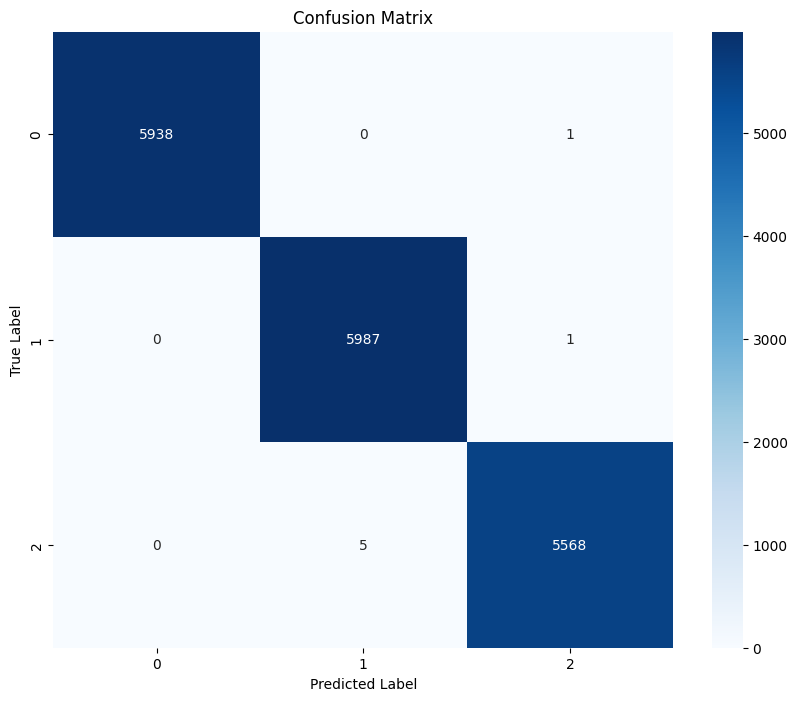

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9998    0.9999      5939
           1     0.9992    0.9998    0.9995      5988
           2     0.9996    0.9991    0.9994      5573

    accuracy                         0.9996     17500
   macro avg     0.9996    0.9996    0.9996     17500
weighted avg     0.9996    0.9996    0.9996     17500



In [15]:
test_report(phobert, test_vlsp_2016_dataloader, device)

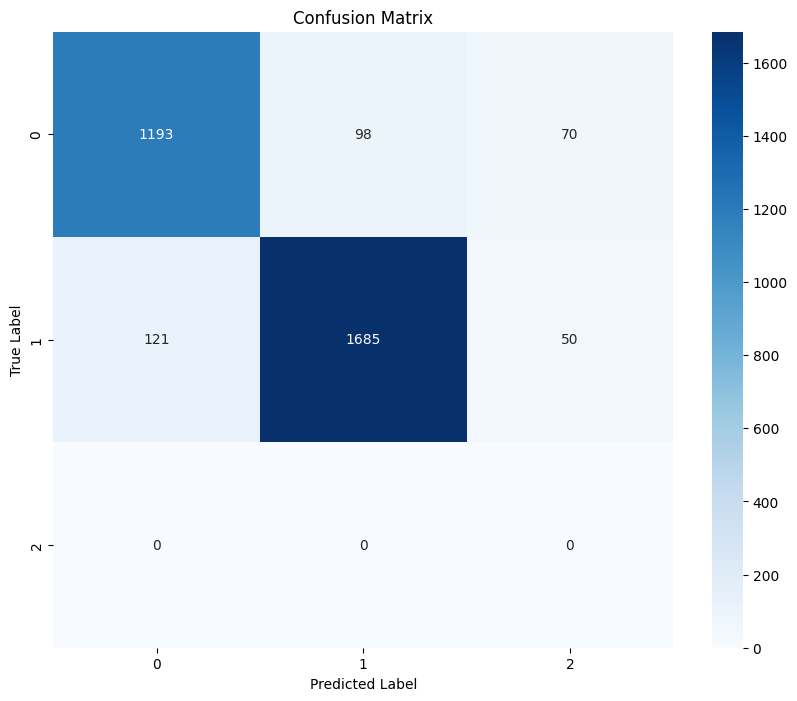

Classification Report:
              precision    recall  f1-score   support

           0     0.9079    0.8766    0.8920      1361
           1     0.9450    0.9079    0.9261      1856
           2     0.0000    0.0000    0.0000         0

    accuracy                         0.8946      3217
   macro avg     0.6177    0.5948    0.6060      3217
weighted avg     0.9293    0.8946    0.9116      3217



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
test_report(phobert, test_aivivn_2019_dataloader, device)

In [17]:
# Remove DataParallel wrapper and access the original model
if isinstance(phobert, nn.DataParallel):
    phobert = phobert.module
#Save model
torch.save(phobert.state_dict(), "/kaggle/working/phobert_sentiment_analysis.pth")

# Test SA task

In [18]:
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("vinai/phobert-base", output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [19]:
# Định nghĩa lớp mô hình tùy chỉnh
class PhoBERT(nn.Module):
    def __init__(self, bert_model):
        super(PhoBERT, self).__init__()
        self.bert = bert_model
        self.mlp = nn.Sequential(
            nn.Linear(768 * 5, 512),  # 768*5 cho BERT
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3)  # num_classes là số lượng lớp trong bài toán của bạn
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Lấy 5 lớp ẩn cuối cùng của token [CLS]
        last_hidden_states = outputs.hidden_states[-5:]
        cls_embeddings = torch.cat([state[:, 0, :] for state in last_hidden_states], dim=1)

        # Đưa qua MLP
        logits = self.mlp(cls_embeddings)
        return logits

In [20]:
phobert = PhoBERT(model)
phobert.to(device)

PhoBERT(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

In [21]:
state_dict = torch.load("/kaggle/working/phobert_sentiment_analysis.pth")
phobert.load_state_dict(state_dict)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    phobert = nn.DataParallel(phobert)

Using 2 GPUs


In [22]:
test_vlsp_2016 = pd.read_csv('/kaggle/input/vlsp-2016/test.csv')
test_aivivn_2019 = pd.read_csv('/kaggle/input/aivivn-2019/test.csv')

# Tạo dataloader cho tập test VLSP 2016
test_vlsp_2016_dataloader = create_dataloader(test_vlsp_2016, tokenizer, rdrsegmenter, batch_size)
test_aivivn_2019_dataloader = create_dataloader(test_aivivn_2019, tokenizer, rdrsegmenter, batch_size)

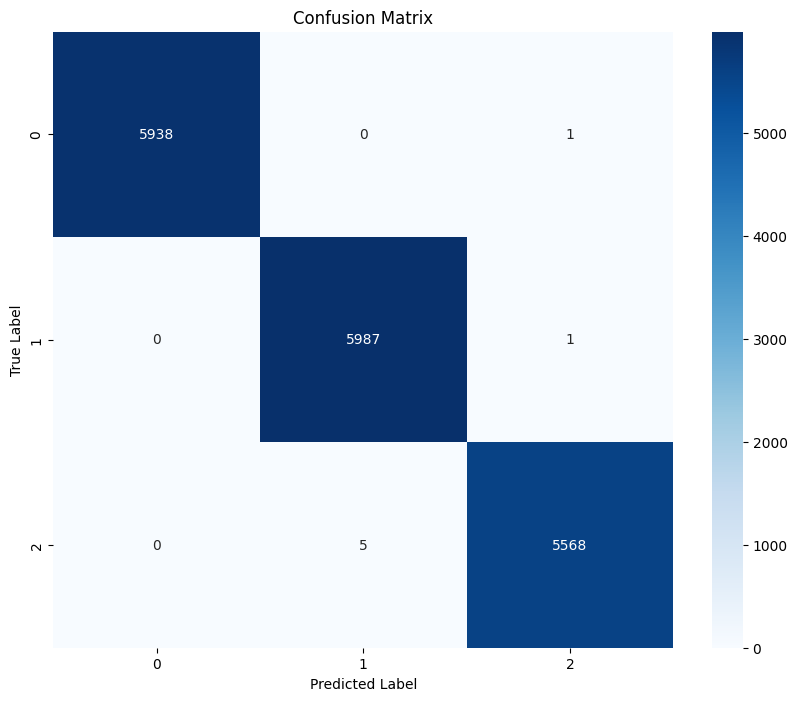

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9998    0.9999      5939
           1     0.9992    0.9998    0.9995      5988
           2     0.9996    0.9991    0.9994      5573

    accuracy                         0.9996     17500
   macro avg     0.9996    0.9996    0.9996     17500
weighted avg     0.9996    0.9996    0.9996     17500



In [23]:
test_report(phobert, test_vlsp_2016_dataloader, device)

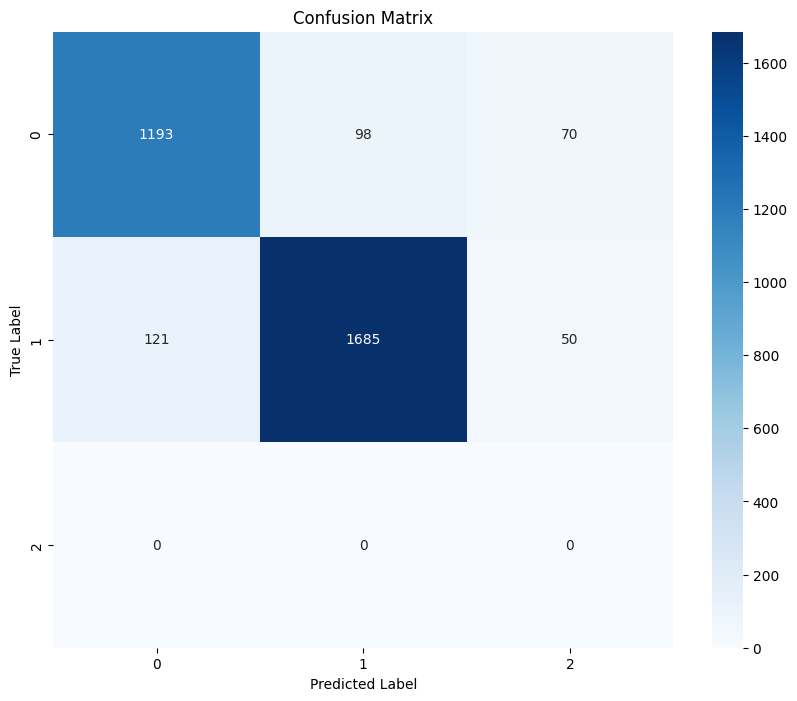

Classification Report:
              precision    recall  f1-score   support

           0     0.9079    0.8766    0.8920      1361
           1     0.9450    0.9079    0.9261      1856
           2     0.0000    0.0000    0.0000         0

    accuracy                         0.8946      3217
   macro avg     0.6177    0.5948    0.6060      3217
weighted avg     0.9293    0.8946    0.9116      3217



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
test_report(phobert, test_aivivn_2019_dataloader, device)